## Set up
### Importing libraries

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from itertools import combinations

### Data load & enrichment

In [15]:
data_folder = '.'

additional_features = pd.read_csv(f"{data_folder}/data.csv").drop("Id", axis=1)
additional_features = additional_features.fillna(additional_features.mean())
additional_features = additional_features.fillna('N/A')
base_features = pd.read_csv(f"{data_folder}/Houseprice_data_scaled.csv")
for c in base_features.columns:
    try:
        additional_features = additional_features.drop([c], axis=1)
    except KeyError:
        next

### Parameters & Constants

In [16]:
# Params
SHOW_CAT_TO_NUM_WARNING = False
ADDITIONAL_FEATURES_SELECT = ['MSSubClass', 'BsmtExposure']
LAMBDA_RIDGE = 0.16
LAMBDA_LASSO = 0.05


# Constants
ADDITIONAL_FEATURES_FIXED = ['LotFrontage', 'LotShape']
ADDITIONAL_FEATURES = ADDITIONAL_FEATURES_FIXED + ADDITIONAL_FEATURES_SELECT
# Trying my damn best to natually map a categorical to numerical 
CAT_MAPS = {
    "LotShape": {
        "Reg": 3,
        "IR1": 2,
        "IR2": 1,
        "IR3": 0,
    },
    'MSZoning': {
        'A': 0,
        'I': 1,
        'FV': 2,
        'RH': 3,
        'RM': 4,
        'RL': 5,
        'RP': 6,
        'C': 7,
    },
    'Utilities': {
        'ELO': 0,
        'NoSeWa': 1,
        'NoSewr': 2,
        'AllPub': 3,
    },
    'LotConfig': {
        'Inside': 0,
        'Corner': 1,
        'CulDSac': 2,
        'FR2': 3,
        'FR3': 4,
    },
    'LandSlope': {
        'Gtl': 2,
        'Mod': 1,
        'Sev': 0,
    },
    'BldgType': {
        '1Fam': 4,
        '2FmCon': 3,
        'Duplx': 2,
        'TwnhsE': 1,
        'Twnhsl': 0,
    },
    'HouseStyle': {
        '1Story': 0,
        '1.5Unf': 1,
        '1.5Fin': 2,
        '2Story': 3,
        '2.5Unf': 4,
        '2.5Fin': 5,
        'SFoyer': 6,
        'SLvl': 7,
    },
    "ExterQual": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "ExterCond": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "BsmtQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "BsmtCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "BsmtExposure": {
        "Gd": 4,
        "Av": 3,
        "Mn": 2,
        "No": 1,
        "NA": 0,
    },
    "BsmtFinType1": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0,
    },
    "BsmtFinType2": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0,
    },
    "HeatingQC": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "Electrical": {
        "Sbrkr": 3,
        "FuseA": 2,
        "FuseF": 1,
        "FuseP": 0,
        "Mix": 1.5,
    },
    "KitchenQual": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "Functional": {
        "Min1": 6,
        "Min2": 5,
        "Mod": 4,
        "Maj1": 3,
        "Maj2": 2,
        "Sev": 1,
        "Sal": 0,
    },
    "FireplaceQu": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "GarageType": {
        "NA": 0,
        "Attchd": 1,
        "Basment": 2,
        "BuiltIn": 3,
        "Carport": 4,
        "Detchd": 5,
        "2Types": 2.5,
    },
    "GarageFinish": {
        "Fin": 3,
        "RFn": 2,
        "Unf": 1,
        "NA": 0,
    },
    "GarageQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "GarageCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "PavedDrive": {
        "Y": 2,
        "P": 1,
        "N": 0,
    },
    "PoolQC": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "NA": 0,
    },
    "Fence": {
        "GdPrv": 4,
        "GdWo": 3,
        "MnPrv": 2,
        "MnWw": 1,
        "NA": 0,
    },
}

### Helper functions

In [17]:
def add_features(base, feature_name):
    """ 
    Outputs a dataframe which equals base_features plus any feature_name from additional_features. 
    Any categorical features will be naively converts to numerical values. All the feature values will be scaled.
    Any missing values (N/A) are filled with average values for this feature
    """
    rep_base = base.copy()
    def add_single_feature(single_feature):
        if is_numeric_dtype(additional_features[single_feature].dtype):
            rep_base[single_feature] = additional_features[single_feature]
        else:
            f_list = np.setdiff1d(additional_features[single_feature].unique(), ['N/A'])
            try:
                f_map = CAT_MAPS[single_feature]
            except KeyError:
#                 print("Warning: Can't find defined feature mapping for {} and it is automatically mapped to numerical".format(single_feature))
                f_map = dict(zip(f_list, range(len(f_list))))
            if SHOW_CAT_TO_NUM_WARNING:
                print("Warning: feature {} is categorical. Mapping to numerical...".format(single_feature))
                print("Mapping: {}".format(f_map))    
            rep_base[single_feature] = additional_features[single_feature].map(f_map)
            # TODO: what to do for NA in categorical features?
            rep_base[single_feature] = rep_base[single_feature].replace('N/A', np.nan)
            rep_base[single_feature] = rep_base[single_feature].fillna(rep_base[single_feature].mean())
        rep_base[single_feature] = (rep_base[single_feature] - rep_base[single_feature].mean()) / rep_base[single_feature].std()
    if type(feature_name) == str:
        add_single_feature(feature_name)
    else:
        for f in feature_name:
            add_single_feature(f)
    return rep_base

def split_dataset(dataset, k_fold=False):
    """ 
    Split input dataset into training, validation and test set (in this order) of size 1800, 600 and whatever left.
    In case of cross validation, train/val will be lists
    """
    idx_lst = np.arange(len(dataset))
    # Should really get rid of all the magic numbers
    if k_fold:
        np.random.shuffle(idx_lst)
        train_val_idx = idx_lst[:1800+600]
        test = dataset.iloc[idx_lst[1800+600:len(dataset)]]
        pods = []
        for i in range(4):
            pods.append(idx_lst[600*i:600*(i+1)])
        train = []
        val = []
        for i in range(4):
            val.append(dataset.iloc[pods[i]])
            train.append(dataset.iloc[np.concatenate([pods[j] for j in set(range(4)) - set([i])])])
    else:
        train = dataset.iloc[idx_lst[:1800]]
        val = dataset.iloc[idx_lst[1800:1800+600]]
        test = dataset.iloc[idx_lst[1800+600:len(dataset)]]
    return train, val, test

def split_xy(dataset, value_name="SalePrice"):
    """ Split input data set into feature and value """
    try:
        return dataset.drop(value_name, axis=1), dataset[[value_name]]
    except AttributeError:
        return [(d.drop(value_name, axis=1), d[[value_name]]) for d in dataset]

def regression(features, method='linear', alpha=0, cross_validation=None, cv_parameter=None):
    """ 
    Run a regression of choice with additional features added to base_features
    
    :param features: A list of features available in dataframe additional_features
    :param method: One of "linear", "ridge" or "lasso"
    :param alpha: Alpha pamameter used for ridge or lasso regression. Should be lambda in Hull's book times # of 
                  observations for ridge regression or half of lambda for lasso regression.
    :param random: Whether to split training/validation/test data sets randomly or not
    :param cross_validation: Method of cross validation. Only supports k-fold for now. If cross validation is used, output 
                             mse and coeffs are averaged results from cross validations
    :param cv_parameter: A tuple of numerical parameters used in cross validation. E.g. sample size p for training set in an
                         exhausive cross validation, or k in a k-fold.
    
    :return: A dictionary containing coeffients and model mse
    """
    # Select features
    df = add_features(base_features, list(features))
    
    # Split data set and split each into X and y where y is the price, and X is set of features
    train, val, test = [split_xy(x) for x in split_dataset(df, k_fold=(cross_validation == 'k-fold'))]
    
    # Fit model
    def fit_model(train_set, val_set, alpha):
        reg_model = {
            'linear': LinearRegression(),
            'ridge': Ridge(alpha=alpha),
            'lasso': Lasso(alpha=alpha),
        }[method.lower()]
        reg_model.fit(*train_set)
    
        return {
            'coeffs': pd.DataFrame(
                [
                    ['intercept'] + list(train_set[0]),
                    list(reg_model.intercept_) + list(reg_model.coef_ if method == 'lasso' else reg_model.coef_[0])
                ]
            ).transpose().set_index(0),
            'mse': mse(val_set[1], reg_model.predict(val_set[0])),
            'reg_model': reg_model,
            'test_set': test,
        }
    
    def with_cv(alpha):
        coeffs = []
        mse = []
        if cross_validation == 'k-fold':
            for i in range(len(train)):
                rs = fit_model(train[i], val[i], alpha)
                coeffs.append(rs['coeffs'])
                mses.append(rs['mse'])
            return {
                'coeffs': pd.DataFrame(pd.concat(coeffs, axis=1).mean(axis=1)),
                'mse': np.array(mses).mean(),
                'reg_model': rs['reg_model'],
                'test_set': test,
            }
        else:
            return fit_model(train, val, alpha)
    
    try:
        return with_cv(float(alpha))
    except TypeError:
        return [with_cv(float(a)) for a in alpha]


## Feature Selections
First, use lasso on all the feature, and only look at features that survived lasso.  
Then, for a fixed alpha level, select two features that minimizes mse using either linear, ridge or lasso regression  
Using ridge below since ridge in general gives a lower MSE than lasso  

We can see that a few important features popped out, e.g.
* BsmtExposure
* MSSubClass
* ExterQual

We will use *BsmtExposure* and *MSSubClass* together with *LotShape* and *LotFrontage* as additional features

In [36]:
# Assumes all the features are added. Look at what are the non zero features after lasso
tmp = regression(list(set(additional_features.columns) - set(['Sale Price'])), method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']
ok_features = []
for i in tmp[abs(tmp[1]) > 0.01].index:
    if i in additional_features.columns:
        ok_features.append(i)

# Use Ridge regression to look at mse and select feature pairs
fdf = {
    'feature 1': [],
    'feature 2': [],
    'mse': [],
}
for feature_pair in list(combinations(set(additional_features.columns) - set(['SalePrice']), 2)):
    fdf['feature 1'].append(feature_pair[0])
    fdf['feature 2'].append(feature_pair[1])
    fdf['mse'].append(regression(feature_pair, method='ridge', alpha=LAMBDA_RIDGE*1800)['mse'])
fdf = pd.DataFrame(fdf)
fdf.sort_values(by='mse')

# Compare back to ok_features. Really any good feature_pair shoulnd't of been dropped by lasso
tmp = []
for i in fdf.iterrows():
    if i[1]['feature 1'] in ok_features and i[1]['feature 2'] in ok_features:
        tmp.append(i[1])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(tmp).sort_values(by='mse'))

          feature 1      feature 2       mse
898    BsmtExposure     MSSubClass  0.103085
1117     MSSubClass      ExterQual  0.104897
916    BsmtExposure      ExterQual  0.105873
186      MasVnrArea     MSSubClass  0.107445
204      MasVnrArea      ExterQual  0.108068
1107     MSSubClass    KitchenQual  0.108587
180      MasVnrArea   BsmtExposure  0.108783
1113     MSSubClass   GarageFinish  0.109023
906    BsmtExposure    KitchenQual  0.109122
1446   GarageFinish      ExterQual  0.109272
923    BsmtExposure   KitchenAbvGr  0.109897
574   SaleCondition     MSSubClass  0.110286
1329    KitchenQual      ExterQual  0.110439
1511      ExterQual   KitchenAbvGr  0.110516
912    BsmtExposure   GarageFinish  0.110545
592   SaleCondition      ExterQual  0.110582
568   SaleCondition   BsmtExposure  0.110970
194      MasVnrArea    KitchenQual  0.111004
1124     MSSubClass   KitchenAbvGr  0.111422
200      MasVnrArea   GarageFinish  0.112142
1325    KitchenQual   GarageFinish  0.112853
1114     M

## Regression Analysis I

Use first 1800 as training set, next 800 as validation set and the rest as test set  

### Linear Regression

In [37]:
rs_lr_1 = regression(ADDITIONAL_FEATURES, method='linear')
print(f"MSE on validation set for linear regression: {rs_lr_1['mse']}")
rs_lr_1['coeffs']

MSE on validation set for linear regression: 0.09960727060456982


,1
0,
intercept,-0.0129726
LotArea,0.0548482
OverallQual,0.201896
OverallCond,0.0862549
YearBuilt,0.149519
YearRemodAdd,0.0263943
BsmtFinSF1,0.100459
BsmtUnfSF,-0.0178838
TotalBsmtSF,0.106858


### Ridge Regression

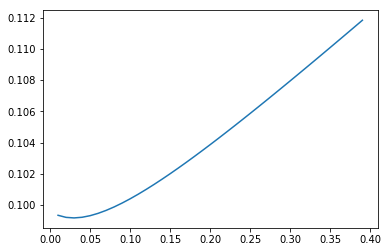

,1
0,
intercept,-0.0129029
LotArea,0.0470686
OverallQual,0.177341
OverallCond,0.0623393
YearBuilt,0.0857532
YearRemodAdd,0.0511777
BsmtFinSF1,0.0974717
BsmtUnfSF,-0.00991339
TotalBsmtSF,0.092521


In [26]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

### Lasso Regression

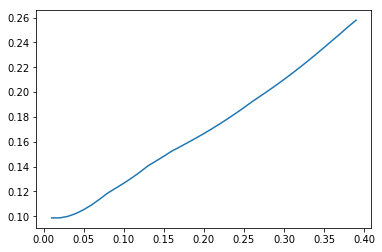

,1
0,
intercept,-0.0121483
LotArea,0.043024
OverallQual,0.256619
OverallCond,0.0305921
YearBuilt,0.0872562
YearRemodAdd,0.0524516
BsmtFinSF1,0.111113
BsmtUnfSF,-0
TotalBsmtSF,0.0855628


In [27]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']


### Use Ridge Regression on Test set

$\lambda$ set to 0.16

In [29]:
rs_1 = regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800)
coeffs_1 = rs_1['coeffs']
mse_1 = mse(rs_1['test_set'][1], rs_1['reg_model'].predict(rs_1['test_set'][0]))

print(f"MSE on test set: {mse_1}")
coeffs_1

MSE on test set: 0.10801029262317446


,1
0,
intercept,-0.0129029
LotArea,0.0470686
OverallQual,0.177341
OverallCond,0.0623393
YearBuilt,0.0857532
YearRemodAdd,0.0511777
BsmtFinSF1,0.0974717
BsmtUnfSF,-0.00991339
TotalBsmtSF,0.092521


## Regression Analysis II

Randomly determine training set, validation set and test set  
Perform k-fold cross-validatoin and take the average for MSE and coefficients. In this case we will use $k=4$ since we have set validation set to have 600 records and training set + validation set has 2400 records. 

### Linear Regression

In [31]:
rs_lr_2 = regression(ADDITIONAL_FEATURES, method='linear', cross_validation='k-fold')
print(f"MSE on validation set for linear regression: {rs_lr_2['mse']}")
rs_lr_2['coeffs']

MSE on validation set for linear regression: 0.15795584373233185


,0
0,
intercept,2.971538e+01
LotArea,4.526262e-02
OverallQual,2.018441e-01
OverallCond,8.383838e-02
YearBuilt,1.460965e-01
YearRemodAdd,3.453565e-02
BsmtFinSF1,9.789655e-02
BsmtUnfSF,-2.759477e-02
TotalBsmtSF,1.049490e-01


### Ridge Regression

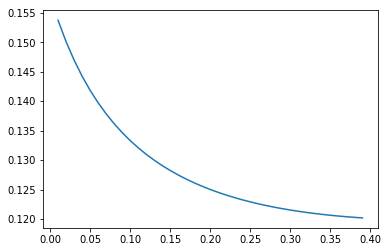

,0
0,
intercept,0.003819
LotArea,0.061064
OverallQual,0.185676
OverallCond,0.057495
YearBuilt,0.084832
YearRemodAdd,0.057465
BsmtFinSF1,0.098420
BsmtUnfSF,-0.016786
TotalBsmtSF,0.100347


In [32]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='ridge', alpha=alphas, cross_validation='k-fold')]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800, cross_validation='k-fold')['coeffs']

### Lasso Regression

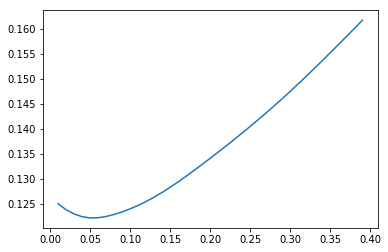

,0
0,
intercept,-0.000089
LotArea,0.033672
OverallQual,0.260798
OverallCond,0.026772
YearBuilt,0.079601
YearRemodAdd,0.055611
BsmtFinSF1,0.116210
BsmtUnfSF,-0.000000
TotalBsmtSF,0.081381


In [33]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='lasso', alpha=alphas, cross_validation='k-fold')]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='lasso', alpha=LAMBDA_LASSO/2, cross_validation='k-fold')['coeffs']

### Use Ridge Regression on Test set

$\lambda$ set to 0.16

In [34]:
rs_2 = regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800, cross_validation='k-fold')
coeffs_2 = rs_2['coeffs']
mse_2 = mse(rs_2['test_set'][1], rs_2['reg_model'].predict(rs_2['test_set'][0]))

print(f"MSE on test set: {mse_2}")
coeffs_2

MSE on test set: 0.11058300463842416


,0
0,
intercept,0.000691
LotArea,0.051979
OverallQual,0.181780
OverallCond,0.057243
YearBuilt,0.081456
YearRemodAdd,0.055956
BsmtFinSF1,0.097344
BsmtUnfSF,-0.017627
TotalBsmtSF,0.090873


## Observations
A good observation is that as lambda level increases, the average magnitude of coefficients decreases in ridge and lasso regression

Average magnitude of coefficients vs lambda level

Ridge Regression


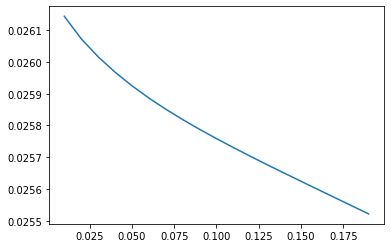

Lasso Regression


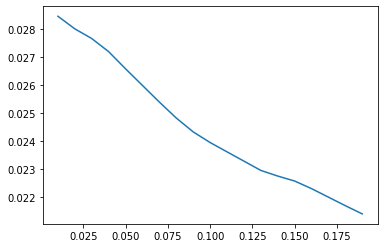

In [122]:
# Yvonne's for loop

lambdas = np.arange(0.01, 0.2, 0.01)
alphas = {'ridge': lambdas * 1800, 'lasso': lambdas / 2}

print("Average magnitude of coefficients vs lambda level\n")
for m in ['ridge', 'lasso']: 
    print(f'{m.capitalize()} Regression')
    plt.plot(lambdas, [float(shit['coeffs'].mean()) for shit in regression(ADDITIONAL_FEATURES_SELECT2, method=m, alpha=alphas[m])])
    plt.show()